In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset



In [2]:

# Define the image limit
BATCH_SIZE = 64
TRAIN_SIZE = 500 * BATCH_SIZE
TEST_SIZE = 10 * BATCH_SIZE
LOSS_EVERY = 1
EPOCHS = 1
SPLIT = 'train'
WEIGHT_DECAY=0
LEARNING_RATE = .0001

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

class CachedImageNet(ImageNet):

    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path) or random() < .01:
            # Image transformations
            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imgnet_input = F.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)

            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(imgnet_input)
            hook.remove()
            assert features is not None
            features = features.squeeze(0)
            if os.path.exists(cache_path):
                saved_features = torch.load(cache_path).to(device)
                assert torch.equal(features,saved_features)

            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='0.9'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train loader contains 500 batches.
Test loader contains 10 batches.


torch.Size([64, 1, 224, 224])


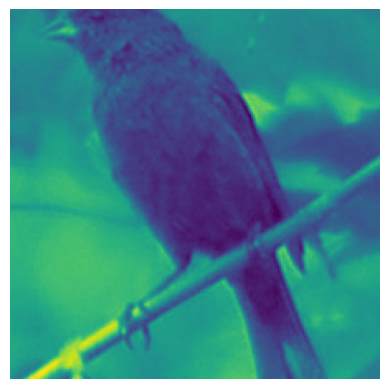

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:
class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=768,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=768, out_channels=512,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=512, out_channels=384,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=384, out_channels=256,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=1, padding=0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, kernel_size=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)



# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parametrs: ", count_parameters(model))


Total parametrs:  24511329


In [5]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [6]:
import torch


# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in enumerate(train_loader):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


Epoch 1, Batch 1, LR: 0.000100, Loss: 0.9610


Epoch 1, Batch 2, LR: 0.000100, Loss: 0.9764


Epoch 1, Batch 3, LR: 0.000100, Loss: 0.7971


Epoch 1, Batch 4, LR: 0.000100, Loss: 0.7497


Epoch 1, Batch 5, LR: 0.000100, Loss: 0.7266


Epoch 1, Batch 6, LR: 0.000100, Loss: 0.6992


Epoch 1, Batch 7, LR: 0.000100, Loss: 0.6827


Epoch 1, Batch 8, LR: 0.000100, Loss: 0.6831


Epoch 1, Batch 9, LR: 0.000100, Loss: 0.6602


Epoch 1, Batch 10, LR: 0.000100, Loss: 0.6487


Epoch 1, Batch 11, LR: 0.000100, Loss: 0.6391


Epoch 1, Batch 12, LR: 0.000100, Loss: 0.6615


Epoch 1, Batch 13, LR: 0.000100, Loss: 0.6114


Epoch 1, Batch 14, LR: 0.000100, Loss: 0.6406


Epoch 1, Batch 15, LR: 0.000100, Loss: 0.6399


Epoch 1, Batch 16, LR: 0.000100, Loss: 0.6261


Epoch 1, Batch 17, LR: 0.000100, Loss: 0.6140


Epoch 1, Batch 18, LR: 0.000100, Loss: 0.6176


Epoch 1, Batch 19, LR: 0.000100, Loss: 0.6069


Epoch 1, Batch 20, LR: 0.000100, Loss: 0.6133


Epoch 1, Batch 21, LR: 0.000100, Loss: 0.5987


Epoch 1, Batch 22, LR: 0.000100, Loss: 0.6164


Epoch 1, Batch 23, LR: 0.000099, Loss: 0.6119


Epoch 1, Batch 24, LR: 0.000099, Loss: 0.6204


Epoch 1, Batch 25, LR: 0.000099, Loss: 0.5906


Epoch 1, Batch 26, LR: 0.000099, Loss: 0.6047


Epoch 1, Batch 27, LR: 0.000099, Loss: 0.6088


Epoch 1, Batch 28, LR: 0.000099, Loss: 0.5938


Epoch 1, Batch 29, LR: 0.000099, Loss: 0.6057


Epoch 1, Batch 30, LR: 0.000099, Loss: 0.5880


Epoch 1, Batch 31, LR: 0.000099, Loss: 0.5834


Epoch 1, Batch 32, LR: 0.000099, Loss: 0.6062


Epoch 1, Batch 33, LR: 0.000099, Loss: 0.5977


Epoch 1, Batch 34, LR: 0.000099, Loss: 0.5983


Epoch 1, Batch 35, LR: 0.000099, Loss: 0.6074


Epoch 1, Batch 36, LR: 0.000099, Loss: 0.5987


Epoch 1, Batch 37, LR: 0.000099, Loss: 0.6021


Epoch 1, Batch 38, LR: 0.000099, Loss: 0.5860


Epoch 1, Batch 39, LR: 0.000099, Loss: 0.5984


Epoch 1, Batch 40, LR: 0.000098, Loss: 0.6070


Epoch 1, Batch 41, LR: 0.000098, Loss: 0.5891


Epoch 1, Batch 42, LR: 0.000098, Loss: 0.5899


Epoch 1, Batch 43, LR: 0.000098, Loss: 0.5808


Epoch 1, Batch 44, LR: 0.000098, Loss: 0.5922


Epoch 1, Batch 45, LR: 0.000098, Loss: 0.5673


Epoch 1, Batch 46, LR: 0.000098, Loss: 0.5924


Epoch 1, Batch 47, LR: 0.000098, Loss: 0.5991


Epoch 1, Batch 48, LR: 0.000098, Loss: 0.5958


Epoch 1, Batch 49, LR: 0.000098, Loss: 0.5906


Epoch 1, Batch 50, LR: 0.000098, Loss: 0.5918


Epoch 1, Batch 51, LR: 0.000097, Loss: 0.6019


Epoch 1, Batch 52, LR: 0.000097, Loss: 0.5853


Epoch 1, Batch 53, LR: 0.000097, Loss: 0.5854


Epoch 1, Batch 54, LR: 0.000097, Loss: 0.5890


Epoch 1, Batch 55, LR: 0.000097, Loss: 0.5747


Epoch 1, Batch 56, LR: 0.000097, Loss: 0.5871


Epoch 1, Batch 57, LR: 0.000097, Loss: 0.5836


Epoch 1, Batch 58, LR: 0.000097, Loss: 0.5916


Epoch 1, Batch 59, LR: 0.000097, Loss: 0.5711


Epoch 1, Batch 60, LR: 0.000096, Loss: 0.5691


Epoch 1, Batch 61, LR: 0.000096, Loss: 0.5943


Epoch 1, Batch 62, LR: 0.000096, Loss: 0.5773


Epoch 1, Batch 63, LR: 0.000096, Loss: 0.5669


Epoch 1, Batch 64, LR: 0.000096, Loss: 0.5838


Epoch 1, Batch 65, LR: 0.000096, Loss: 0.5857


Epoch 1, Batch 66, LR: 0.000096, Loss: 0.5843


Epoch 1, Batch 67, LR: 0.000096, Loss: 0.5815


Epoch 1, Batch 68, LR: 0.000096, Loss: 0.5694


Epoch 1, Batch 69, LR: 0.000095, Loss: 0.5875


Epoch 1, Batch 70, LR: 0.000095, Loss: 0.5849


Epoch 1, Batch 71, LR: 0.000095, Loss: 0.5809


Epoch 1, Batch 72, LR: 0.000095, Loss: 0.5859


Epoch 1, Batch 73, LR: 0.000095, Loss: 0.5851


Epoch 1, Batch 74, LR: 0.000095, Loss: 0.5769


Epoch 1, Batch 75, LR: 0.000095, Loss: 0.5760


Epoch 1, Batch 76, LR: 0.000094, Loss: 0.5766


Epoch 1, Batch 77, LR: 0.000094, Loss: 0.5889


Epoch 1, Batch 78, LR: 0.000094, Loss: 0.6124


Epoch 1, Batch 79, LR: 0.000094, Loss: 0.5818


Epoch 1, Batch 80, LR: 0.000094, Loss: 0.5808


Epoch 1, Batch 81, LR: 0.000094, Loss: 0.5790


Epoch 1, Batch 82, LR: 0.000094, Loss: 0.5718


Epoch 1, Batch 83, LR: 0.000093, Loss: 0.5824


Epoch 1, Batch 84, LR: 0.000093, Loss: 0.5808


Epoch 1, Batch 85, LR: 0.000093, Loss: 0.6028


Epoch 1, Batch 86, LR: 0.000093, Loss: 0.5835


Epoch 1, Batch 87, LR: 0.000093, Loss: 0.5851


Epoch 1, Batch 88, LR: 0.000093, Loss: 0.5901


Epoch 1, Batch 89, LR: 0.000092, Loss: 0.5795


Epoch 1, Batch 90, LR: 0.000092, Loss: 0.5642


Epoch 1, Batch 91, LR: 0.000092, Loss: 0.5921


Epoch 1, Batch 92, LR: 0.000092, Loss: 0.5745


Epoch 1, Batch 93, LR: 0.000092, Loss: 0.5901


Epoch 1, Batch 94, LR: 0.000092, Loss: 0.5879


Epoch 1, Batch 95, LR: 0.000091, Loss: 0.5944


Epoch 1, Batch 96, LR: 0.000091, Loss: 0.5672


Epoch 1, Batch 97, LR: 0.000091, Loss: 0.5782


Epoch 1, Batch 98, LR: 0.000091, Loss: 0.5751


Epoch 1, Batch 99, LR: 0.000091, Loss: 0.5926


Epoch 1, Batch 100, LR: 0.000090, Loss: 0.5813


Epoch 1, Batch 101, LR: 0.000090, Loss: 0.5682


Epoch 1, Batch 102, LR: 0.000090, Loss: 0.5869


Epoch 1, Batch 103, LR: 0.000090, Loss: 0.5976


Epoch 1, Batch 104, LR: 0.000090, Loss: 0.5710


Epoch 1, Batch 105, LR: 0.000090, Loss: 0.5959


Epoch 1, Batch 106, LR: 0.000089, Loss: 0.5845


Epoch 1, Batch 107, LR: 0.000089, Loss: 0.5739


Epoch 1, Batch 108, LR: 0.000089, Loss: 0.5841


Epoch 1, Batch 109, LR: 0.000089, Loss: 0.5951


Epoch 1, Batch 110, LR: 0.000089, Loss: 0.5884


Epoch 1, Batch 111, LR: 0.000088, Loss: 0.5856


Epoch 1, Batch 112, LR: 0.000088, Loss: 0.5733


Epoch 1, Batch 113, LR: 0.000088, Loss: 0.5853


Epoch 1, Batch 114, LR: 0.000088, Loss: 0.5853


Epoch 1, Batch 115, LR: 0.000088, Loss: 0.5801


Epoch 1, Batch 116, LR: 0.000087, Loss: 0.5898


Epoch 1, Batch 117, LR: 0.000087, Loss: 0.5885


Epoch 1, Batch 118, LR: 0.000087, Loss: 0.5705


Epoch 1, Batch 119, LR: 0.000087, Loss: 0.5846


Epoch 1, Batch 120, LR: 0.000086, Loss: 0.5607


Epoch 1, Batch 121, LR: 0.000086, Loss: 0.5846


Epoch 1, Batch 122, LR: 0.000086, Loss: 0.5786


Epoch 1, Batch 123, LR: 0.000086, Loss: 0.5810


Epoch 1, Batch 124, LR: 0.000086, Loss: 0.5897


Epoch 1, Batch 125, LR: 0.000085, Loss: 0.5778


Epoch 1, Batch 126, LR: 0.000085, Loss: 0.5701


Epoch 1, Batch 127, LR: 0.000085, Loss: 0.5830


Epoch 1, Batch 128, LR: 0.000085, Loss: 0.5547


Epoch 1, Batch 129, LR: 0.000084, Loss: 0.5848


Epoch 1, Batch 130, LR: 0.000084, Loss: 0.5740


Epoch 1, Batch 131, LR: 0.000084, Loss: 0.5758


Epoch 1, Batch 132, LR: 0.000084, Loss: 0.5863


Epoch 1, Batch 133, LR: 0.000084, Loss: 0.5828


Epoch 1, Batch 134, LR: 0.000083, Loss: 0.5844


Epoch 1, Batch 135, LR: 0.000083, Loss: 0.5853


Epoch 1, Batch 136, LR: 0.000083, Loss: 0.5918


Epoch 1, Batch 137, LR: 0.000083, Loss: 0.5791


Epoch 1, Batch 138, LR: 0.000082, Loss: 0.5946


Epoch 1, Batch 139, LR: 0.000082, Loss: 0.5836


Epoch 1, Batch 140, LR: 0.000082, Loss: 0.5817


Epoch 1, Batch 141, LR: 0.000082, Loss: 0.5862


Epoch 1, Batch 142, LR: 0.000081, Loss: 0.5673


Epoch 1, Batch 143, LR: 0.000081, Loss: 0.6063


Epoch 1, Batch 144, LR: 0.000081, Loss: 0.5699


Epoch 1, Batch 145, LR: 0.000081, Loss: 0.5794


Epoch 1, Batch 146, LR: 0.000080, Loss: 0.5653


Epoch 1, Batch 147, LR: 0.000080, Loss: 0.5832


Epoch 1, Batch 148, LR: 0.000080, Loss: 0.5652


Epoch 1, Batch 149, LR: 0.000080, Loss: 0.5713


Epoch 1, Batch 150, LR: 0.000079, Loss: 0.5889


Epoch 1, Batch 151, LR: 0.000079, Loss: 0.5653


Epoch 1, Batch 152, LR: 0.000079, Loss: 0.5796


Epoch 1, Batch 153, LR: 0.000079, Loss: 0.5753


Epoch 1, Batch 154, LR: 0.000078, Loss: 0.5716


Epoch 1, Batch 155, LR: 0.000078, Loss: 0.5741


Epoch 1, Batch 156, LR: 0.000078, Loss: 0.5832


Epoch 1, Batch 157, LR: 0.000078, Loss: 0.5779


Epoch 1, Batch 158, LR: 0.000077, Loss: 0.5766


Epoch 1, Batch 159, LR: 0.000077, Loss: 0.5636


Epoch 1, Batch 160, LR: 0.000077, Loss: 0.5799


Epoch 1, Batch 161, LR: 0.000077, Loss: 0.5728


Epoch 1, Batch 162, LR: 0.000076, Loss: 0.5732


Epoch 1, Batch 163, LR: 0.000076, Loss: 0.5748


Epoch 1, Batch 164, LR: 0.000076, Loss: 0.5766


Epoch 1, Batch 165, LR: 0.000075, Loss: 0.5718


Epoch 1, Batch 166, LR: 0.000075, Loss: 0.5850


Epoch 1, Batch 167, LR: 0.000075, Loss: 0.5798


Epoch 1, Batch 168, LR: 0.000075, Loss: 0.5781


Epoch 1, Batch 169, LR: 0.000074, Loss: 0.5691


Epoch 1, Batch 170, LR: 0.000074, Loss: 0.5631


Epoch 1, Batch 171, LR: 0.000074, Loss: 0.5743


Epoch 1, Batch 172, LR: 0.000074, Loss: 0.5723


Epoch 1, Batch 173, LR: 0.000073, Loss: 0.5536


Epoch 1, Batch 174, LR: 0.000073, Loss: 0.5784


Epoch 1, Batch 175, LR: 0.000073, Loss: 0.5808


Epoch 1, Batch 176, LR: 0.000072, Loss: 0.5729


Epoch 1, Batch 177, LR: 0.000072, Loss: 0.5920


Epoch 1, Batch 178, LR: 0.000072, Loss: 0.5740


Epoch 1, Batch 179, LR: 0.000072, Loss: 0.5733


Epoch 1, Batch 180, LR: 0.000071, Loss: 0.5674


Epoch 1, Batch 181, LR: 0.000071, Loss: 0.5731


Epoch 1, Batch 182, LR: 0.000071, Loss: 0.5709


Epoch 1, Batch 183, LR: 0.000070, Loss: 0.5753


Epoch 1, Batch 184, LR: 0.000070, Loss: 0.5854


Epoch 1, Batch 185, LR: 0.000070, Loss: 0.5925


Epoch 1, Batch 186, LR: 0.000070, Loss: 0.5754


Epoch 1, Batch 187, LR: 0.000069, Loss: 0.5773


Epoch 1, Batch 188, LR: 0.000069, Loss: 0.5810


Epoch 1, Batch 189, LR: 0.000069, Loss: 0.5760


Epoch 1, Batch 190, LR: 0.000068, Loss: 0.5655


Epoch 1, Batch 191, LR: 0.000068, Loss: 0.5749


Epoch 1, Batch 192, LR: 0.000068, Loss: 0.5614


Epoch 1, Batch 193, LR: 0.000068, Loss: 0.5890


Epoch 1, Batch 194, LR: 0.000067, Loss: 0.5899


Epoch 1, Batch 195, LR: 0.000067, Loss: 0.5809


Epoch 1, Batch 196, LR: 0.000067, Loss: 0.5861


Epoch 1, Batch 197, LR: 0.000066, Loss: 0.5745


Epoch 1, Batch 198, LR: 0.000066, Loss: 0.5746


Epoch 1, Batch 199, LR: 0.000066, Loss: 0.5741


Epoch 1, Batch 200, LR: 0.000065, Loss: 0.5724


Epoch 1, Batch 201, LR: 0.000065, Loss: 0.5865


Epoch 1, Batch 202, LR: 0.000065, Loss: 0.5914


Epoch 1, Batch 203, LR: 0.000065, Loss: 0.5942


Epoch 1, Batch 204, LR: 0.000064, Loss: 0.5996


Epoch 1, Batch 205, LR: 0.000064, Loss: 0.5960


Epoch 1, Batch 206, LR: 0.000064, Loss: 0.5830


Epoch 1, Batch 207, LR: 0.000063, Loss: 0.5962


Epoch 1, Batch 208, LR: 0.000063, Loss: 0.5840


Epoch 1, Batch 209, LR: 0.000063, Loss: 0.5486


Epoch 1, Batch 210, LR: 0.000062, Loss: 0.5858


Epoch 1, Batch 211, LR: 0.000062, Loss: 0.5708


Epoch 1, Batch 212, LR: 0.000062, Loss: 0.5698


Epoch 1, Batch 213, LR: 0.000062, Loss: 0.5839


Epoch 1, Batch 214, LR: 0.000061, Loss: 0.5927


Epoch 1, Batch 215, LR: 0.000061, Loss: 0.5826


Epoch 1, Batch 216, LR: 0.000061, Loss: 0.5824


Epoch 1, Batch 217, LR: 0.000060, Loss: 0.5831


Epoch 1, Batch 218, LR: 0.000060, Loss: 0.5716


Epoch 1, Batch 219, LR: 0.000060, Loss: 0.6057


Epoch 1, Batch 220, LR: 0.000059, Loss: 0.5779


Epoch 1, Batch 221, LR: 0.000059, Loss: 0.5913


Epoch 1, Batch 222, LR: 0.000059, Loss: 0.5816


Epoch 1, Batch 223, LR: 0.000058, Loss: 0.5746


Epoch 1, Batch 224, LR: 0.000058, Loss: 0.5805


Epoch 1, Batch 225, LR: 0.000058, Loss: 0.5787


Epoch 1, Batch 226, LR: 0.000058, Loss: 0.5713


Epoch 1, Batch 227, LR: 0.000057, Loss: 0.5741


Epoch 1, Batch 228, LR: 0.000057, Loss: 0.5696


Epoch 1, Batch 229, LR: 0.000057, Loss: 0.5626


Epoch 1, Batch 230, LR: 0.000056, Loss: 0.5904


Epoch 1, Batch 231, LR: 0.000056, Loss: 0.5966


Epoch 1, Batch 232, LR: 0.000056, Loss: 0.5683


Epoch 1, Batch 233, LR: 0.000055, Loss: 0.5778


Epoch 1, Batch 234, LR: 0.000055, Loss: 0.5807


Epoch 1, Batch 235, LR: 0.000055, Loss: 0.5829


Epoch 1, Batch 236, LR: 0.000054, Loss: 0.5952


Epoch 1, Batch 237, LR: 0.000054, Loss: 0.5753


Epoch 1, Batch 238, LR: 0.000054, Loss: 0.5835


Epoch 1, Batch 239, LR: 0.000053, Loss: 0.5537


Epoch 1, Batch 240, LR: 0.000053, Loss: 0.5787


Epoch 1, Batch 241, LR: 0.000053, Loss: 0.5823


Epoch 1, Batch 242, LR: 0.000053, Loss: 0.5761


Epoch 1, Batch 243, LR: 0.000052, Loss: 0.5757


Epoch 1, Batch 244, LR: 0.000052, Loss: 0.5740


Epoch 1, Batch 245, LR: 0.000052, Loss: 0.5771


Epoch 1, Batch 246, LR: 0.000051, Loss: 0.5738


Epoch 1, Batch 247, LR: 0.000051, Loss: 0.5888


Epoch 1, Batch 248, LR: 0.000051, Loss: 0.5773


Epoch 1, Batch 249, LR: 0.000050, Loss: 0.5872


Epoch 1, Batch 250, LR: 0.000050, Loss: 0.5890


Epoch 1, Batch 251, LR: 0.000050, Loss: 0.5750


Epoch 1, Batch 252, LR: 0.000049, Loss: 0.5578


Epoch 1, Batch 253, LR: 0.000049, Loss: 0.5611


Epoch 1, Batch 254, LR: 0.000049, Loss: 0.5933


Epoch 1, Batch 255, LR: 0.000048, Loss: 0.5788


Epoch 1, Batch 256, LR: 0.000048, Loss: 0.5762


Epoch 1, Batch 257, LR: 0.000048, Loss: 0.5872


Epoch 1, Batch 258, LR: 0.000047, Loss: 0.5614


Epoch 1, Batch 259, LR: 0.000047, Loss: 0.5838


Epoch 1, Batch 260, LR: 0.000047, Loss: 0.5748


Epoch 1, Batch 261, LR: 0.000047, Loss: 0.5579


Epoch 1, Batch 262, LR: 0.000046, Loss: 0.5747


Epoch 1, Batch 263, LR: 0.000046, Loss: 0.5854


Epoch 1, Batch 264, LR: 0.000046, Loss: 0.5417


Epoch 1, Batch 265, LR: 0.000045, Loss: 0.5896


Epoch 1, Batch 266, LR: 0.000045, Loss: 0.5756


Epoch 1, Batch 267, LR: 0.000045, Loss: 0.5754


Epoch 1, Batch 268, LR: 0.000044, Loss: 0.5739


Epoch 1, Batch 269, LR: 0.000044, Loss: 0.5605


Epoch 1, Batch 270, LR: 0.000044, Loss: 0.5831


Epoch 1, Batch 271, LR: 0.000043, Loss: 0.5557


Epoch 1, Batch 272, LR: 0.000043, Loss: 0.5773


Epoch 1, Batch 273, LR: 0.000043, Loss: 0.5580


Epoch 1, Batch 274, LR: 0.000042, Loss: 0.5528


Epoch 1, Batch 275, LR: 0.000042, Loss: 0.5698


Epoch 1, Batch 276, LR: 0.000042, Loss: 0.5861


Epoch 1, Batch 277, LR: 0.000042, Loss: 0.5757


Epoch 1, Batch 278, LR: 0.000041, Loss: 0.5811


Epoch 1, Batch 279, LR: 0.000041, Loss: 0.5784


Epoch 1, Batch 280, LR: 0.000041, Loss: 0.5683


Epoch 1, Batch 281, LR: 0.000040, Loss: 0.5748


Epoch 1, Batch 282, LR: 0.000040, Loss: 0.5673


Epoch 1, Batch 283, LR: 0.000040, Loss: 0.5766


Epoch 1, Batch 284, LR: 0.000039, Loss: 0.5788


Epoch 1, Batch 285, LR: 0.000039, Loss: 0.5785


Epoch 1, Batch 286, LR: 0.000039, Loss: 0.5794


Epoch 1, Batch 287, LR: 0.000038, Loss: 0.5769


Epoch 1, Batch 288, LR: 0.000038, Loss: 0.5793


Epoch 1, Batch 289, LR: 0.000038, Loss: 0.5484


Epoch 1, Batch 290, LR: 0.000038, Loss: 0.5854


Epoch 1, Batch 291, LR: 0.000037, Loss: 0.5918


Epoch 1, Batch 292, LR: 0.000037, Loss: 0.5503


Epoch 1, Batch 293, LR: 0.000037, Loss: 0.5763


Epoch 1, Batch 294, LR: 0.000036, Loss: 0.5884


Epoch 1, Batch 295, LR: 0.000036, Loss: 0.5869


Epoch 1, Batch 296, LR: 0.000036, Loss: 0.5944


Epoch 1, Batch 297, LR: 0.000035, Loss: 0.5732


Epoch 1, Batch 298, LR: 0.000035, Loss: 0.5767


Epoch 1, Batch 299, LR: 0.000035, Loss: 0.5605


Epoch 1, Batch 300, LR: 0.000035, Loss: 0.5740


Epoch 1, Batch 301, LR: 0.000034, Loss: 0.5891


Epoch 1, Batch 302, LR: 0.000034, Loss: 0.5850


Epoch 1, Batch 303, LR: 0.000034, Loss: 0.5561


Epoch 1, Batch 304, LR: 0.000033, Loss: 0.5690


Epoch 1, Batch 305, LR: 0.000033, Loss: 0.5853


Epoch 1, Batch 306, LR: 0.000033, Loss: 0.5782


Epoch 1, Batch 307, LR: 0.000032, Loss: 0.5767


Epoch 1, Batch 308, LR: 0.000032, Loss: 0.5915


Epoch 1, Batch 309, LR: 0.000032, Loss: 0.5798


Epoch 1, Batch 310, LR: 0.000032, Loss: 0.5852


Epoch 1, Batch 311, LR: 0.000031, Loss: 0.5694


Epoch 1, Batch 312, LR: 0.000031, Loss: 0.5841


Epoch 1, Batch 313, LR: 0.000031, Loss: 0.5751


Epoch 1, Batch 314, LR: 0.000030, Loss: 0.5755


Epoch 1, Batch 315, LR: 0.000030, Loss: 0.5775


Epoch 1, Batch 316, LR: 0.000030, Loss: 0.5822


Epoch 1, Batch 317, LR: 0.000030, Loss: 0.5619


Epoch 1, Batch 318, LR: 0.000029, Loss: 0.5679


Epoch 1, Batch 319, LR: 0.000029, Loss: 0.5786


Epoch 1, Batch 320, LR: 0.000029, Loss: 0.5697


Epoch 1, Batch 321, LR: 0.000028, Loss: 0.5771


Epoch 1, Batch 322, LR: 0.000028, Loss: 0.5804


Epoch 1, Batch 323, LR: 0.000028, Loss: 0.5648


Epoch 1, Batch 324, LR: 0.000028, Loss: 0.5735


Epoch 1, Batch 325, LR: 0.000027, Loss: 0.5849


Epoch 1, Batch 326, LR: 0.000027, Loss: 0.5802


Epoch 1, Batch 327, LR: 0.000027, Loss: 0.5735


Epoch 1, Batch 328, LR: 0.000026, Loss: 0.5693


Epoch 1, Batch 329, LR: 0.000026, Loss: 0.5580


Epoch 1, Batch 330, LR: 0.000026, Loss: 0.5799


Epoch 1, Batch 331, LR: 0.000026, Loss: 0.5662


Epoch 1, Batch 332, LR: 0.000025, Loss: 0.5763


Epoch 1, Batch 333, LR: 0.000025, Loss: 0.5650


Epoch 1, Batch 334, LR: 0.000025, Loss: 0.5641


Epoch 1, Batch 335, LR: 0.000025, Loss: 0.5688


Epoch 1, Batch 336, LR: 0.000024, Loss: 0.5874


Epoch 1, Batch 337, LR: 0.000024, Loss: 0.5809


Epoch 1, Batch 338, LR: 0.000024, Loss: 0.5713


Epoch 1, Batch 339, LR: 0.000023, Loss: 0.5840


Epoch 1, Batch 340, LR: 0.000023, Loss: 0.5851


Epoch 1, Batch 341, LR: 0.000023, Loss: 0.5795


Epoch 1, Batch 342, LR: 0.000023, Loss: 0.5738


Epoch 1, Batch 343, LR: 0.000022, Loss: 0.5818


Epoch 1, Batch 344, LR: 0.000022, Loss: 0.5745


Epoch 1, Batch 345, LR: 0.000022, Loss: 0.5717


Epoch 1, Batch 346, LR: 0.000022, Loss: 0.5975


Epoch 1, Batch 347, LR: 0.000021, Loss: 0.5812


Epoch 1, Batch 348, LR: 0.000021, Loss: 0.6008


Epoch 1, Batch 349, LR: 0.000021, Loss: 0.5978


Epoch 1, Batch 350, LR: 0.000021, Loss: 0.5737


Epoch 1, Batch 351, LR: 0.000020, Loss: 0.5665


Epoch 1, Batch 352, LR: 0.000020, Loss: 0.5815


Epoch 1, Batch 353, LR: 0.000020, Loss: 0.5852


Epoch 1, Batch 354, LR: 0.000020, Loss: 0.5683


Epoch 1, Batch 355, LR: 0.000019, Loss: 0.5830


Epoch 1, Batch 356, LR: 0.000019, Loss: 0.5712


Epoch 1, Batch 357, LR: 0.000019, Loss: 0.5819


Epoch 1, Batch 358, LR: 0.000019, Loss: 0.5767


Epoch 1, Batch 359, LR: 0.000018, Loss: 0.5763


Epoch 1, Batch 360, LR: 0.000018, Loss: 0.5848


Epoch 1, Batch 361, LR: 0.000018, Loss: 0.5749


Epoch 1, Batch 362, LR: 0.000018, Loss: 0.5897


Epoch 1, Batch 363, LR: 0.000017, Loss: 0.5622


Epoch 1, Batch 364, LR: 0.000017, Loss: 0.5792


Epoch 1, Batch 365, LR: 0.000017, Loss: 0.5583


Epoch 1, Batch 366, LR: 0.000017, Loss: 0.5852


Epoch 1, Batch 367, LR: 0.000016, Loss: 0.5821


Epoch 1, Batch 368, LR: 0.000016, Loss: 0.5726


Epoch 1, Batch 369, LR: 0.000016, Loss: 0.5597


Epoch 1, Batch 370, LR: 0.000016, Loss: 0.5749


Epoch 1, Batch 371, LR: 0.000016, Loss: 0.5702


Epoch 1, Batch 372, LR: 0.000015, Loss: 0.5765


Epoch 1, Batch 373, LR: 0.000015, Loss: 0.5858


Epoch 1, Batch 374, LR: 0.000015, Loss: 0.5612


Epoch 1, Batch 375, LR: 0.000015, Loss: 0.5668


Epoch 1, Batch 376, LR: 0.000014, Loss: 0.5910


Epoch 1, Batch 377, LR: 0.000014, Loss: 0.5509


Epoch 1, Batch 378, LR: 0.000014, Loss: 0.5879


Epoch 1, Batch 379, LR: 0.000014, Loss: 0.5815


Epoch 1, Batch 380, LR: 0.000014, Loss: 0.5647


Epoch 1, Batch 381, LR: 0.000013, Loss: 0.5883


Epoch 1, Batch 382, LR: 0.000013, Loss: 0.5861


Epoch 1, Batch 383, LR: 0.000013, Loss: 0.5608


Epoch 1, Batch 384, LR: 0.000013, Loss: 0.5768


Epoch 1, Batch 385, LR: 0.000012, Loss: 0.5695


Epoch 1, Batch 386, LR: 0.000012, Loss: 0.5902


Epoch 1, Batch 387, LR: 0.000012, Loss: 0.5920


Epoch 1, Batch 388, LR: 0.000012, Loss: 0.5702


Epoch 1, Batch 389, LR: 0.000012, Loss: 0.5742


Epoch 1, Batch 390, LR: 0.000011, Loss: 0.5744


Epoch 1, Batch 391, LR: 0.000011, Loss: 0.5790


Epoch 1, Batch 392, LR: 0.000011, Loss: 0.5778


Epoch 1, Batch 393, LR: 0.000011, Loss: 0.5776


Epoch 1, Batch 394, LR: 0.000011, Loss: 0.5726


Epoch 1, Batch 395, LR: 0.000010, Loss: 0.5783


Epoch 1, Batch 396, LR: 0.000010, Loss: 0.5802


Epoch 1, Batch 397, LR: 0.000010, Loss: 0.5639


Epoch 1, Batch 398, LR: 0.000010, Loss: 0.5843


Epoch 1, Batch 399, LR: 0.000010, Loss: 0.5798


Epoch 1, Batch 400, LR: 0.000010, Loss: 0.5807


Epoch 1, Batch 401, LR: 0.000009, Loss: 0.5654


Epoch 1, Batch 402, LR: 0.000009, Loss: 0.5742


Epoch 1, Batch 403, LR: 0.000009, Loss: 0.5711


Epoch 1, Batch 404, LR: 0.000009, Loss: 0.5824


Epoch 1, Batch 405, LR: 0.000009, Loss: 0.5977


Epoch 1, Batch 406, LR: 0.000008, Loss: 0.5784


Epoch 1, Batch 407, LR: 0.000008, Loss: 0.5845


Epoch 1, Batch 408, LR: 0.000008, Loss: 0.5781


Epoch 1, Batch 409, LR: 0.000008, Loss: 0.5836


Epoch 1, Batch 410, LR: 0.000008, Loss: 0.5573


Epoch 1, Batch 411, LR: 0.000008, Loss: 0.5702


Epoch 1, Batch 412, LR: 0.000007, Loss: 0.5482


Epoch 1, Batch 413, LR: 0.000007, Loss: 0.5812


Epoch 1, Batch 414, LR: 0.000007, Loss: 0.5793


Epoch 1, Batch 415, LR: 0.000007, Loss: 0.5713


Epoch 1, Batch 416, LR: 0.000007, Loss: 0.5861


Epoch 1, Batch 417, LR: 0.000007, Loss: 0.5664


Epoch 1, Batch 418, LR: 0.000006, Loss: 0.5737


Epoch 1, Batch 419, LR: 0.000006, Loss: 0.5790


Epoch 1, Batch 420, LR: 0.000006, Loss: 0.5842


Epoch 1, Batch 421, LR: 0.000006, Loss: 0.5730


Epoch 1, Batch 422, LR: 0.000006, Loss: 0.5789


Epoch 1, Batch 423, LR: 0.000006, Loss: 0.5725


Epoch 1, Batch 424, LR: 0.000006, Loss: 0.5893


Epoch 1, Batch 425, LR: 0.000005, Loss: 0.5590


Epoch 1, Batch 426, LR: 0.000005, Loss: 0.5799


Epoch 1, Batch 427, LR: 0.000005, Loss: 0.5757


Epoch 1, Batch 428, LR: 0.000005, Loss: 0.5640


Epoch 1, Batch 429, LR: 0.000005, Loss: 0.5760


Epoch 1, Batch 430, LR: 0.000005, Loss: 0.5676


Epoch 1, Batch 431, LR: 0.000005, Loss: 0.5915


Epoch 1, Batch 432, LR: 0.000004, Loss: 0.5807


Epoch 1, Batch 433, LR: 0.000004, Loss: 0.5736


Epoch 1, Batch 434, LR: 0.000004, Loss: 0.5815


Epoch 1, Batch 435, LR: 0.000004, Loss: 0.5792


Epoch 1, Batch 436, LR: 0.000004, Loss: 0.5837


Epoch 1, Batch 437, LR: 0.000004, Loss: 0.5675


Epoch 1, Batch 438, LR: 0.000004, Loss: 0.5665


Epoch 1, Batch 439, LR: 0.000004, Loss: 0.5727


Epoch 1, Batch 440, LR: 0.000004, Loss: 0.5755


Epoch 1, Batch 441, LR: 0.000003, Loss: 0.5659


Epoch 1, Batch 442, LR: 0.000003, Loss: 0.5639


Epoch 1, Batch 443, LR: 0.000003, Loss: 0.5664


Epoch 1, Batch 444, LR: 0.000003, Loss: 0.5905


Epoch 1, Batch 445, LR: 0.000003, Loss: 0.5631


Epoch 1, Batch 446, LR: 0.000003, Loss: 0.5653


Epoch 1, Batch 447, LR: 0.000003, Loss: 0.5815


Epoch 1, Batch 448, LR: 0.000003, Loss: 0.5749


Epoch 1, Batch 449, LR: 0.000003, Loss: 0.5826


Epoch 1, Batch 450, LR: 0.000002, Loss: 0.5813


Epoch 1, Batch 451, LR: 0.000002, Loss: 0.5638


Epoch 1, Batch 452, LR: 0.000002, Loss: 0.5929


Epoch 1, Batch 453, LR: 0.000002, Loss: 0.5694


Epoch 1, Batch 454, LR: 0.000002, Loss: 0.5895


Epoch 1, Batch 455, LR: 0.000002, Loss: 0.5645


Epoch 1, Batch 456, LR: 0.000002, Loss: 0.5737


Epoch 1, Batch 457, LR: 0.000002, Loss: 0.5857


Epoch 1, Batch 458, LR: 0.000002, Loss: 0.5578


Epoch 1, Batch 459, LR: 0.000002, Loss: 0.5900


Epoch 1, Batch 460, LR: 0.000002, Loss: 0.5560


Epoch 1, Batch 461, LR: 0.000001, Loss: 0.5891


Epoch 1, Batch 462, LR: 0.000001, Loss: 0.5656


Epoch 1, Batch 463, LR: 0.000001, Loss: 0.5969


Epoch 1, Batch 464, LR: 0.000001, Loss: 0.5867


Epoch 1, Batch 465, LR: 0.000001, Loss: 0.5718


Epoch 1, Batch 466, LR: 0.000001, Loss: 0.5730


Epoch 1, Batch 467, LR: 0.000001, Loss: 0.5704


Epoch 1, Batch 468, LR: 0.000001, Loss: 0.5829


Epoch 1, Batch 469, LR: 0.000001, Loss: 0.5781


Epoch 1, Batch 470, LR: 0.000001, Loss: 0.5887


Epoch 1, Batch 471, LR: 0.000001, Loss: 0.5831


Epoch 1, Batch 472, LR: 0.000001, Loss: 0.5983


Epoch 1, Batch 473, LR: 0.000001, Loss: 0.5836


Epoch 1, Batch 474, LR: 0.000001, Loss: 0.5707


Epoch 1, Batch 475, LR: 0.000001, Loss: 0.5648


Epoch 1, Batch 476, LR: 0.000001, Loss: 0.5984


Epoch 1, Batch 477, LR: 0.000001, Loss: 0.5784


Epoch 1, Batch 478, LR: 0.000000, Loss: 0.5839


Epoch 1, Batch 479, LR: 0.000000, Loss: 0.5852


Epoch 1, Batch 480, LR: 0.000000, Loss: 0.5772


Epoch 1, Batch 481, LR: 0.000000, Loss: 0.5659


Epoch 1, Batch 482, LR: 0.000000, Loss: 0.5635


Epoch 1, Batch 483, LR: 0.000000, Loss: 0.5546


Epoch 1, Batch 484, LR: 0.000000, Loss: 0.5492


Epoch 1, Batch 485, LR: 0.000000, Loss: 0.5784


Epoch 1, Batch 486, LR: 0.000000, Loss: 0.5753


Epoch 1, Batch 487, LR: 0.000000, Loss: 0.5596


Epoch 1, Batch 488, LR: 0.000000, Loss: 0.5929


Epoch 1, Batch 489, LR: 0.000000, Loss: 0.5843


Epoch 1, Batch 490, LR: 0.000000, Loss: 0.5936


Epoch 1, Batch 491, LR: 0.000000, Loss: 0.5770


Epoch 1, Batch 492, LR: 0.000000, Loss: 0.5739


Epoch 1, Batch 493, LR: 0.000000, Loss: 0.5689


Epoch 1, Batch 494, LR: 0.000000, Loss: 0.5764


Epoch 1, Batch 495, LR: 0.000000, Loss: 0.5857


Epoch 1, Batch 496, LR: 0.000000, Loss: 0.5729


Epoch 1, Batch 497, LR: 0.000000, Loss: 0.5728


Epoch 1, Batch 498, LR: 0.000000, Loss: 0.5824


Epoch 1, Batch 499, LR: 0.000000, Loss: 0.5642


Epoch 1, Batch 500, LR: 0.000000, Loss: 0.5823


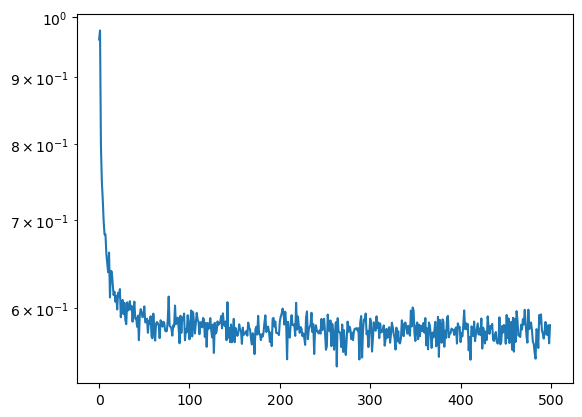

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
# set maximum y to 

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:10,  1.19s/it]

 20%|██        | 2/10 [00:02<00:09,  1.20s/it]

 30%|███       | 3/10 [00:03<00:07,  1.13s/it]

 40%|████      | 4/10 [00:04<00:06,  1.12s/it]

 50%|█████     | 5/10 [00:05<00:05,  1.06s/it]

 60%|██████    | 6/10 [00:06<00:04,  1.04s/it]

 70%|███████   | 7/10 [00:07<00:03,  1.03s/it]

 80%|████████  | 8/10 [00:08<00:02,  1.00s/it]

 90%|█████████ | 9/10 [00:09<00:01,  1.03s/it]

100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

100%|██████████| 10/10 [00:10<00:00,  1.07s/it]

Test Loss: 0.5762


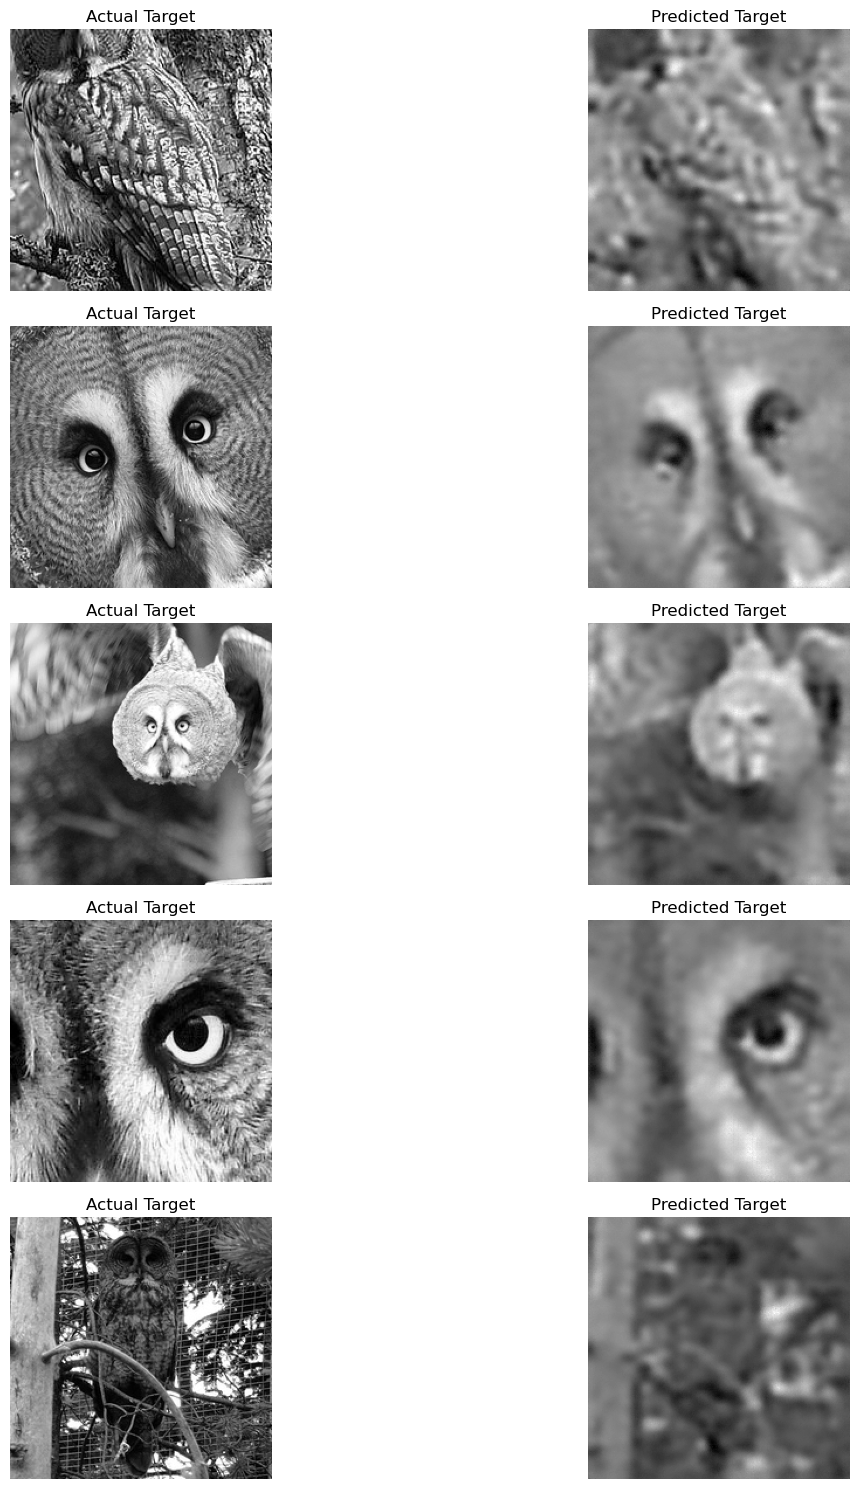

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-7.4812) tensor(7.3930)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
torch.save(model, join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt"))